# Stereopsis and 3D reconstruction

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
plt.rcParams["figure.facecolor"]=(1,1,1,1)

This notebook gives an introduction to basics of 3D reconstruction from a stereo image pair.

## Simple stereo pair

In a simple stereo pair two images (left and right) have been captured using a setup where the cameras are similar, their x axes are collinear, and their y and z axes are parallel. Hence the correspondences always share the same y coordinate, and the disparity is only along the x axis. The disparities are inversely proportional to the depth, and hence, they provide 3D information about the scene. However, recovering the disparity map is often challenging because of lacking details.

Here is an example of a simple stereo pair.

In [3]:
Left = cv2.imread('images/aloeL.jpg')
Right = cv2.imread('images/aloeR.jpg')

(-0.5, 1281.5, 1109.5, -0.5)

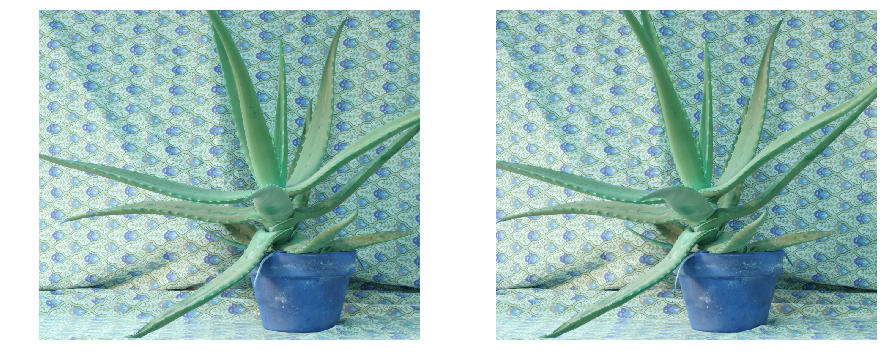

In [4]:
fig=plt.figure(figsize=(15,7))
fig.add_subplot(121)
plt.imshow(Left)
plt.axis('off')
fig.add_subplot(122)
plt.imshow(Right)
plt.axis('off')

In [5]:
gLeft = cv2.cvtColor(Left,cv2.COLOR_RGB2GRAY)
gRight = cv2.cvtColor(Right,cv2.COLOR_RGB2GRAY)

Here is also the corresponding ground truth disparity map.

In [6]:
GT = cv2.imread('images/aloeGT.png')

(-0.5, 1281.5, 1109.5, -0.5)

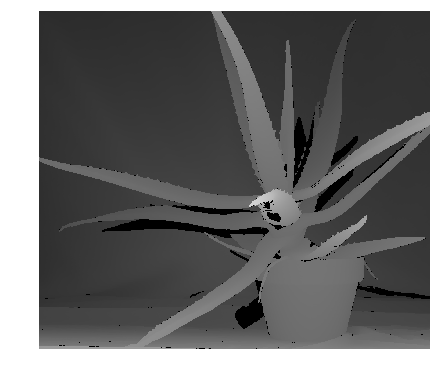

In [7]:
plt.figure(figsize=(7,7))
plt.imshow(GT, cmap='gray')
plt.axis('off')

Next, we use a block-matching based stereo algorithm to reconstruct the disparity map. We assume that the maximum disparity is 256. The resulting depth map is shown below. As we can see there are many error and holes in the depth map obtained. This is a common problem in stereo matching.

In [8]:
stereoMatcher = cv2.StereoBM_create(256)

In [9]:
depth = stereoMatcher.compute(gLeft, gRight)

(-0.5, 1281.5, 1109.5, -0.5)

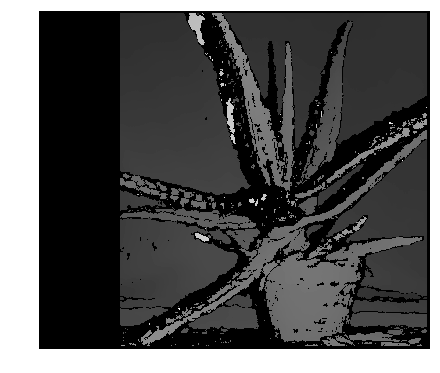

In [10]:
plt.figure(figsize=(7,7))
plt.imshow(depth, cmap='gray')
plt.axis('off')

We also try another method, semi-global block matching algorithm, that is based on the [article](http://www.ifp.uni-stuttgart.de/publications/phowo11/180Hirschmueller.pdf). We can notice that the result is slightly better.

In [11]:
stereoMatcher2 = cv2.StereoSGBM_create(0,256,7)

In [12]:
depth2 = stereoMatcher2.compute(gLeft, gRight)

(-0.5, 1281.5, 1109.5, -0.5)

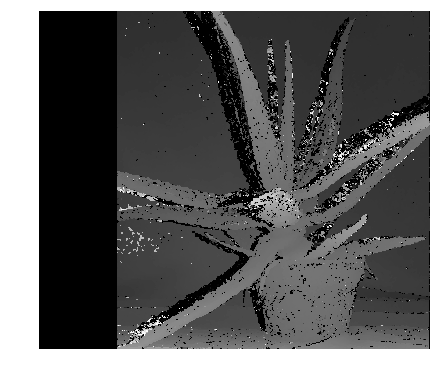

In [13]:
plt.figure(figsize=(7,7))
plt.imshow(depth2, cmap='gray')
plt.axis('off')

## Epipolar geometry

In a general stereo pair the cameras can be in arbitrary positions and orientations. They can even have different internal parameters. In that case we can solve the epipolar geometry between the cameras, and calculate the epipolar lines that help in establishing the correspondences. For every point in the left image there is an epipolar line in the right image where the correspondences are located, and vice versa.

First we read the image pair and use SIFT features to find some matches.


In [14]:
left=cv2.cvtColor(cv2.imread('images/ChairL.jpg'),cv2.COLOR_RGB2GRAY)
right=cv2.cvtColor(cv2.imread('images/ChairR.jpg'),cv2.COLOR_RGB2GRAY)

(-0.5, 911.5, 683.5, -0.5)

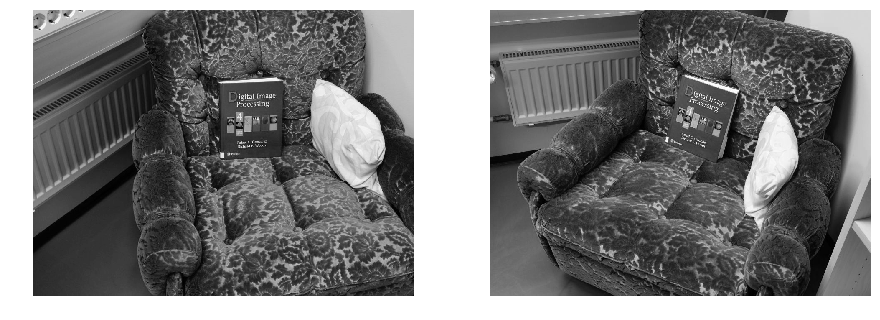

In [15]:
fig=plt.figure(figsize=(15,7))
fig.add_subplot(121)
plt.imshow(left, cmap='gray')
plt.axis('off')
fig.add_subplot(122)
plt.imshow(right, cmap='gray')
plt.axis('off')

In [16]:
sift = cv2.xfeatures2d.SIFT_create()

In [17]:
kp1, desc1 = sift.detectAndCompute(left,None)
kp2, desc2 = sift.detectAndCompute(right,None)

In [18]:
bf = cv2.BFMatcher()

In [19]:
matches = bf.knnMatch(desc1,desc2, k=2)

In [20]:
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])

In [21]:
img = cv2.drawMatchesKnn(left,kp1,right,kp2,good,None,flags=2)

(-0.5, 1823.5, 683.5, -0.5)

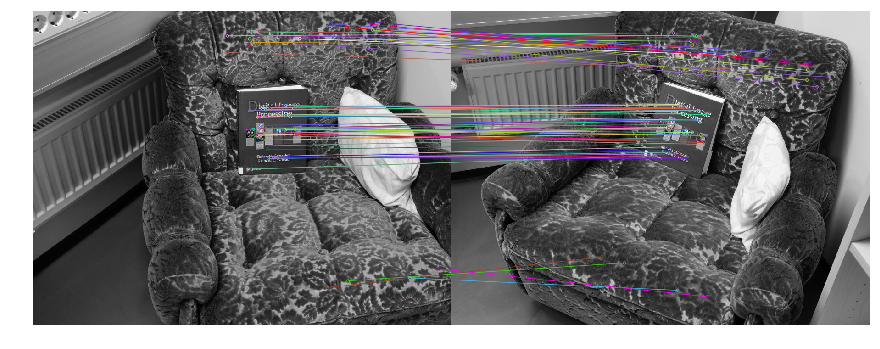

In [22]:
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis('off')

We notice that there are outliers among the matches, so we use RANSAC to estimate the fundamental matrix $\mathbf{F}$ that gives a simple relationship $\mathbf{x'}^T\mathbf{F}\mathbf{x} = 0$ betweeen the valid matches.

In [23]:
pts1 = np.zeros((len(good), 2))
pts2 = np.zeros((len(good), 2))
for i in range(len(good)):
    i1 = good[i][0].queryIdx
    i2 = good[i][0].trainIdx
    pts1[i,:] = kp1[i1].pt
    pts2[i,:] = kp2[i2].pt

In [24]:
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)

Here is the fundamental matrix:

In [25]:
print(F)

[[ 4.10402778e-07 -1.45766216e-06 -2.09780635e-03]
 [-1.22492745e-06 -3.23999030e-07  6.63261977e-03]
 [-1.10416806e-04 -5.09189740e-03  1.00000000e+00]]


We also get the inliers that satisfy the epipolar constraint:

In [26]:
inliers = [good[i] for i in range(len(mask)) if mask[i,0]]

In [27]:
img = cv2.drawMatchesKnn(left,kp1,right,kp2,inliers,None,flags=2)

(-0.5, 1823.5, 683.5, -0.5)

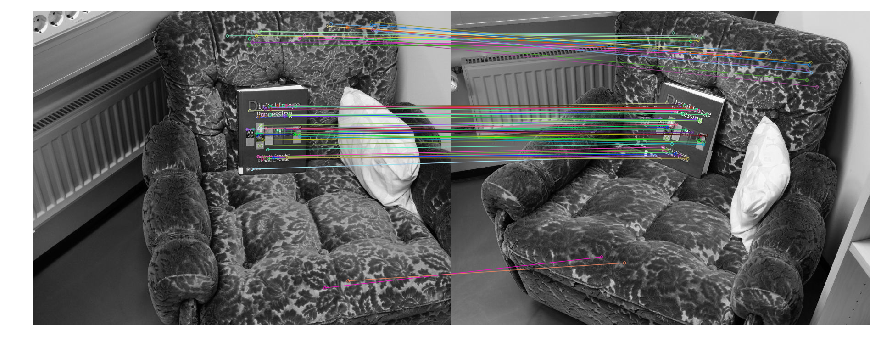

In [28]:
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis('off')

Next, we calculate the epipolar lines in the right image for the points in the left image and visualize few of them below.

In [29]:
lines1 = cv2.computeCorrespondEpilines(pts1, 1, F)

In [30]:
# This function determines the start and the end points of the line.
def line_bb(line, height, width):
    a=line[0]; b=line[1]; c=line[2]
    if b != 0:
        if c*b < 0 and c/b > -height:
            y0 = -c/b; x0 = 0
        if (a*width+c)*b < 0 and (a*width+c)/b > -height:
            y1 = -(a*width+c)/b ; x1 = width
    if a != 0:
        if c*a < 0 and c/a > -width:
            x0 = -c/a; y0 = 0
        if (b*height+c)*a < 0 and (b*height+c)/a > -width:
            x1 = -(b*height+c)/a ; y1 = height
    return x0,y0,x1,y1

(-0.5, 957.625, 683.5, -0.5)

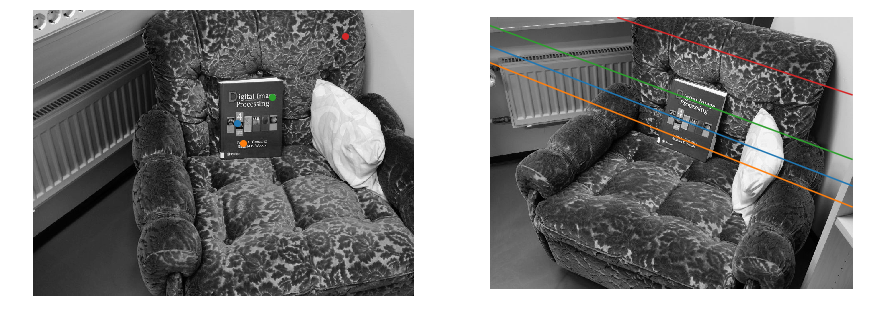

In [31]:
ind=[15,30,60,75]
fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
plt.imshow(left,cmap='gray')
for i in ind:
    plt.plot(pts1[i,0],pts1[i,1],'o')
plt.axis('off')
fig.add_subplot(122)
plt.imshow(right,cmap='gray')
for i in ind:
    x0,y0,x1,y1 = line_bb(lines1[i,0,:],*left.shape)
    plt.plot([x0,x1],[y0,y1])
plt.axis('off')

These are the inlier points:

In [32]:
pt1 = pts1[mask.ravel()==1,:]
pt2 = pts2[mask.ravel()==1,:]

Then we can rectify the images to make them a simple stereo pair where the correspondences have the same y coordinate. The rectified images are show below.

In [33]:
ret, H1, H2 = cv2.stereoRectifyUncalibrated(pt1,pt2,F,left.shape[::-1])

In [34]:
recL = cv2.warpPerspective(left, H1, left.shape[::-1])

In [35]:
recR = cv2.warpPerspective(right, H2, right.shape[::-1])

(-0.5, 911.5, 683.5, -0.5)

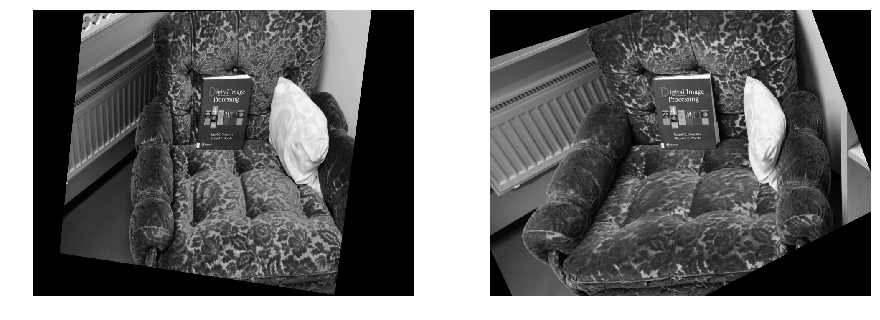

In [36]:
fig=plt.figure(figsize=(15,7))
fig.add_subplot(121)
plt.imshow(recL, cmap='gray')
plt.axis('off')
fig.add_subplot(122)
plt.imshow(recR, cmap='gray')
plt.axis('off')

Using the rectified images we can perform stereo matching with the same methods as above. The disparity map obtained is presented below.

In [37]:
stereoM = cv2.StereoSGBM_create(0,192,3)

In [38]:
dep = stereoM.compute(recL, recR)

In [39]:
mask = (recL > 0).astype(np.uint8)

(-0.5, 911.5, 683.5, -0.5)

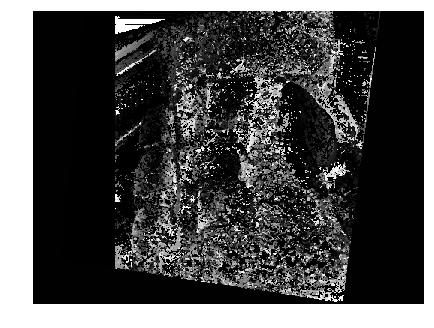

In [40]:
plt.figure(figsize=(7,7))
plt.imshow(dep*mask,cmap='gray')
plt.axis('off')

## Camera calibration

Camera calibration is needed for accurate 3D reconstruction. It is often performed using a known target object such as a checker board pattern. A tutorial on camera calibration is available [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html). For simplicity, we do not perform full calibration in this notebook. Instead, we use a method presented in this [paper](https://pdfs.semanticscholar.org/9145/a453190b87e6530bdf6deb029bec2dc1bb83.pdf) to extract the focal length from the fundamental matrix. Focal length is the most important internal parameter of the camera. We assume that the principal point is located in the center of the image frame and the image does not contain distortion.

We first normalize the image coordinates with respect to the principal point.

In [41]:
ppt = np.array(left.shape[::-1])/2

In [42]:
npts1=pts1-ppt
npts2=pts2-ppt

Then we calculate the fundamental matrix again.

In [43]:
F, mask = cv2.findFundamentalMat(npts1,npts2,cv2.FM_RANSAC)

We use the singular value decomposition (SVD) to estimate the locations of the epipoles.

In [44]:
U, S, V = np.linalg.svd(F)

In [45]:
ep1=V[2,0:2]/V[2,2]
ep2=U[0:2,2]/U[2,2]

The epipoles are normalized to x axis, and the corresponding fundamental matrix is formed.

In [46]:
th1=-np.arctan2(ep1[1],ep1[0])

In [47]:
th2=np.pi-np.arctan2(ep2[1],ep2[0])

In [48]:
R1=np.array([[np.cos(th1),np.sin(th1),0],[-np.sin(th1),np.cos(th1),0],[0,0,1]])
R2=np.array([[np.cos(th2),np.sin(th2),0],[-np.sin(th2),np.cos(th2),0],[0,0,1]])

In [49]:
F2=np.matmul(np.matmul(R2.T,F),R1)

In [50]:
U, S, V = np.linalg.svd(F2)
ep1=V[2,0:2]/V[2,2]
ep2=U[0:2,2]/U[2,2]

The algorithm provides focal lengths for both images.

In [51]:
U2,S2,V2 = np.linalg.svd(F2)
e1=V2[2,:]; e2=U2[:,2]
A=np.linalg.inv(np.diag((U2[2,2],1,-U2[0,2])))
B=np.linalg.inv(np.diag((V2[2,2],1,-V2[2,0])))
R=np.matmul(np.matmul(A,F2),B)
a=R[0,0]; b=R[0,1]; c=R[1,0]; d=R[1,1]
f1=np.sqrt(-a*c*e1[0]**2/(a*c*e1[2]**2+b*d))
f2=np.sqrt(-a*b*e2[0]**2/(a*b*e2[2]**2+c*d))

We assume that the cameras have the same internal parameters, and we use the average as a focal length for both cameras. 

In [52]:
f = (f1+f2)/2

The camera matrix is then created.

In [53]:
C=np.array([[f,0,ppt[0]],[0,f,ppt[1]],[0,0,1]])

## Calibrated stereo

Once the camera matrix is known, we can estimate the essential matrix $\mathbf{E}$ instead of the fundamental matrix. It provides the relationship between normalized image coordinates $\mathbf{y}=\mathbf{C}^{-1}\mathbf{x}$ so that $\mathbf{y'}^T\mathbf{E}\mathbf{y} = 0$.

In [54]:
E, mask = cv2.findEssentialMat(pt1,pt2,C)

Essential matrix can be decomposed into rotation matrix $\mathbf{R}$ and translation vector $\mathbf{t}$. Because of ambiquity there are four possible solutions: ($\mathbf{R_1}$,$\mathbf{t}$), ($\mathbf{R_1}$,$\mathbf{-t}$), ($\mathbf{R_2}$,$\mathbf{t}$), and ($\mathbf{R_2}$,$\mathbf{-t}$). With this approach the translation vector is defined only up to scale. Rotation $\mathbf{R}$ and translation $\mathbf{t}$ are called the pose or external camera parameters.

In [55]:
R1, R2, t =cv2.decomposeEssentialMat(E)

Next, we check how the corresponding epipolar lines look. We reconstruct the fundamental matrix using the equation $\mathbf{F} = \mathbf{C}^{-T} [\mathbf{t}]_\times \mathbf{R} \mathbf{C}^{-1}$, where $[\cdot]_\times$ is a skew symmetric matrix.

In [56]:
def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

In [57]:
Fa = np.matmul(np.matmul(np.matmul(np.linalg.inv(C.T),skew(-t)),R2),np.linalg.inv(C))

In [58]:
lines1 = cv2.computeCorrespondEpilines(pts1, 1, Fa)

(-0.5, 957.625, 683.5, -0.5)

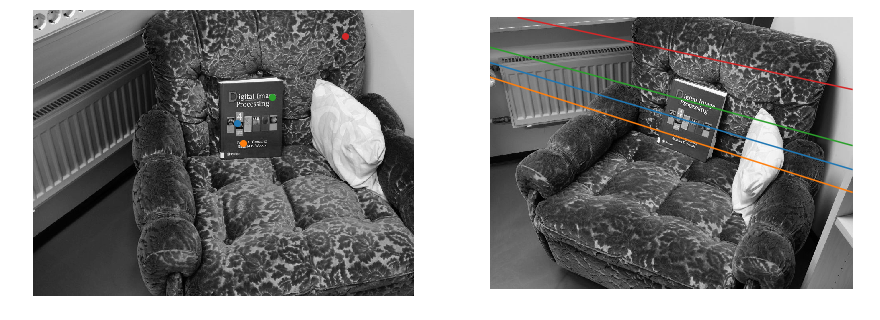

In [59]:
ind=[15,30,60,75]
fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
plt.imshow(left,cmap='gray')
for i in ind:
    plt.plot(pts1[i,0],pts1[i,1],'o')
plt.axis('off')
fig.add_subplot(122)
plt.imshow(right,cmap='gray')
for i in ind:
    x0,y0,x1,y1 = line_bb(lines1[i,0,:],*left.shape)
    plt.plot([x0,x1],[y0,y1])
plt.axis('off')

We can see that the epipolar lines are quite similar to those obtained in the uncalibrated case.

Then we can triangulate the points to the 3D space. For that we need the projection matrices for both cameras. We assume that the left camera defines the world coordinate system. The 3D points obtained are visualized below.

In [60]:
T=np.hstack((R2,-t))

In [61]:
P2=np.matmul(C,T)

In [62]:
P1=np.hstack((C,np.zeros((3,1))))

In [63]:
hpt3d=cv2.cv2.triangulatePoints(P1,P2,pt1.T,pt2.T)

In [64]:
pt3d=cv2.convertPointsFromHomogeneous(hpt3d.T)

Text(0.5,0,'Z')

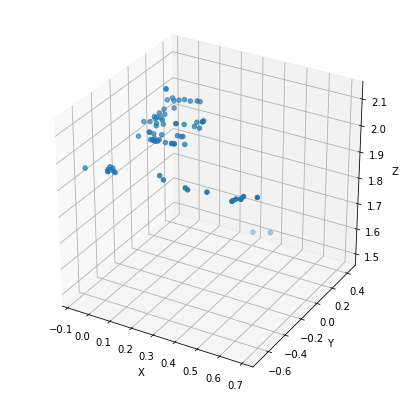

In [65]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pt3d[:,0,0],pt3d[:,0,1],pt3d[:,0,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

We can project the 3D points back to the image coordinates. We need to convert the rotation matrix to axis-angle representation using the [Rodrigues' formula](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula). Projected points are shown below.

In [66]:
rvec,_=cv2.Rodrigues(R2)

In [67]:
p1,_=cv2.projectPoints(pt3d, np.zeros((3,1)), np.zeros((3,1)), C, None)
p2,_=cv2.projectPoints(pt3d, rvec, -t, C, None)

(-0.5, 911.5, 683.5, -0.5)

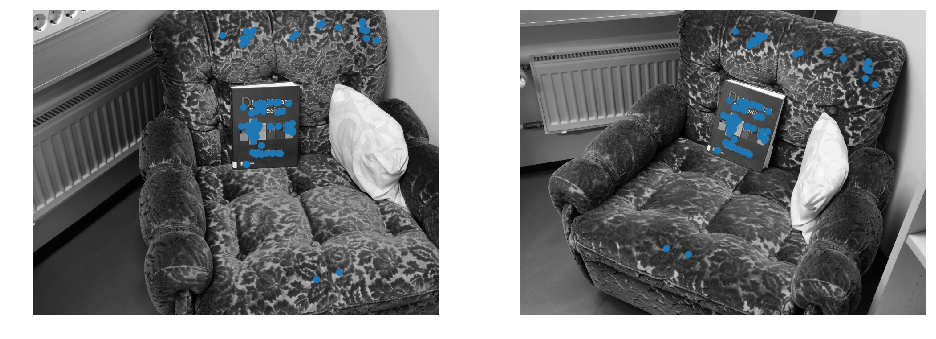

In [68]:
fig = plt.figure(figsize=(16,8))
fig.add_subplot(121)
plt.imshow(left,cmap='gray')
plt.plot(p1[:,0,0],p1[:,0,1],'o')
plt.axis('off')
fig.add_subplot(122)
plt.imshow(right,cmap='gray')
plt.plot(p2[:,0,0],p2[:,0,1],'o')
plt.axis('off')

The stereo pair can be also rectified using the known pose and the internal camera parameters. We assume that there is no lens distortion.

In [69]:
lR,rR,lP,rP,Q,_,_ = cv2.stereoRectify(C,None,C,None,left.shape[::-1],R2,-t)

In [70]:
imSize = (int(left.shape[1]*1.3),left.shape[0])
lMapX, lMapY = cv2.initUndistortRectifyMap(C,None,lR,lP,imSize,cv2.CV_32FC1)
rMapX, rMapY = cv2.initUndistortRectifyMap(C,None,rR,rP,imSize,cv2.CV_32FC1)

In [71]:
recL = cv2.remap(left, lMapX, lMapY, cv2.INTER_LINEAR)
recR = cv2.remap(right, rMapX, rMapY, cv2.INTER_LINEAR)

(-0.5, 1184.5, 683.5, -0.5)

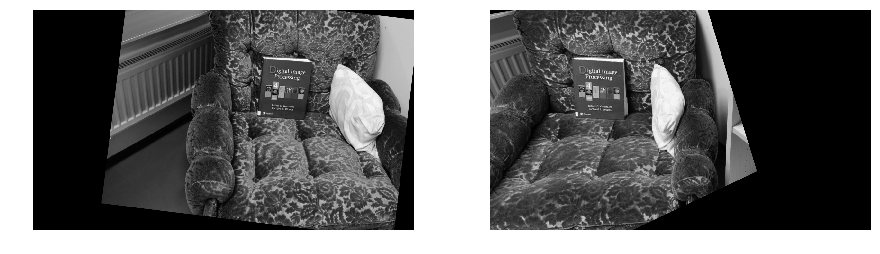

In [72]:
fig=plt.figure(figsize=(15,7))
fig.add_subplot(121)
plt.imshow(recL, cmap='gray')
plt.axis('off')
fig.add_subplot(122)
plt.imshow(recR, cmap='gray')
plt.axis('off')

The same stereo matching algorithm can be again used to get the disparity map.

In [73]:
stereoM = cv2.StereoSGBM_create(-256,256,3)

In [74]:
dep = stereoM.compute(recL, recR)

In [75]:
mask = (recL > 0).astype(np.uint8)

(-0.5, 1184.5, 683.5, -0.5)

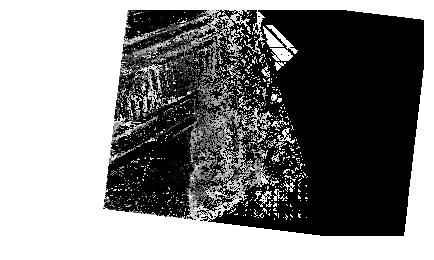

In [76]:
plt.figure(figsize=(7,7))
plt.imshow(dep*mask,cmap='gray')
plt.axis('off')

Finally, the disparity map is converted to 3D coordinates. The scatter plot below shows the result for a subsampled map. 

In [77]:
img3d = cv2.reprojectImageTo3D(dep*mask, Q)

In [78]:
x, y, z = cv2.split(img3d)
x = x[::8,::8]
y = y[::8,::8]
z = z[::8,::8]

Text(0.5,0,'Z')

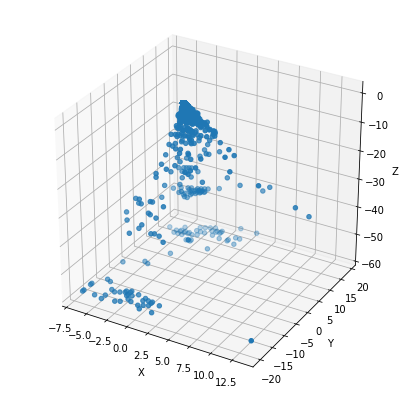

In [79]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x.flatten(),y.flatten(),z.flatten())
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

We can see that the result is not reliable in this case. This is probably due to inaccurate calibration.